In [340]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
import tensorflow as tf
import numpy as np
import os
# plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
DIM = 150
clases = 6

In [369]:

import torch
torch.cuda.is_available()
print(torch.version.cuda)

None


In [366]:
import torch
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

0


AssertionError: Torch not compiled with CUDA enabled

In [341]:
nbatch = 64

train_datagen = ImageDataGenerator( rescale=1./255,
                                    rotation_range=10.,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True
                                  )

test_datagen  = ImageDataGenerator( rescale=1./255 )

train_gen = train_datagen.flow_from_directory(
        'rokas_train',
        target_size=(DIM, DIM),
        color_mode='grayscale',
        batch_size=32,
        classes=['0','1','2','3','4','5'],
        class_mode='categorical'
    )

test_gen = test_datagen.flow_from_directory(
        'rokas_validate',
        target_size=(DIM, DIM),
        color_mode='grayscale',
        batch_size=5,
        classes=['0','1','2','3','4','5'],
        class_mode='categorical'
    )

Found 739 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


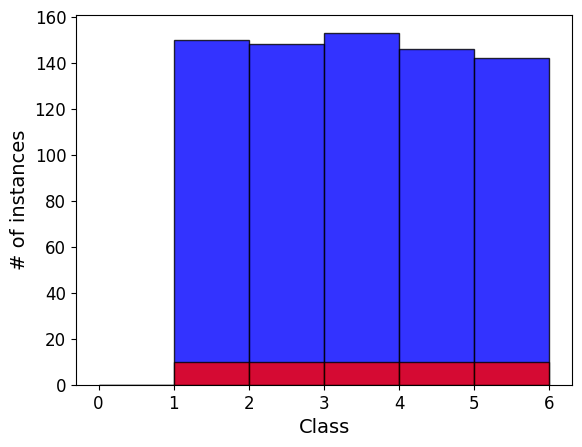

In [342]:
h1,_,_ = plt.hist(train_gen.classes, bins=range(0,7), alpha=0.8, color='blue', edgecolor='black')
h2,_,_ = plt.hist(test_gen.classes,  bins=range(0,7), alpha=0.8, color='red', edgecolor='black')
plt.ylabel('# of instances')
plt.xlabel('Class');

In [343]:
# double check things aren't mixed up
train_gen.class_indices == test_gen.class_indices

True

(32, 150, 150, 1) (32, 6)


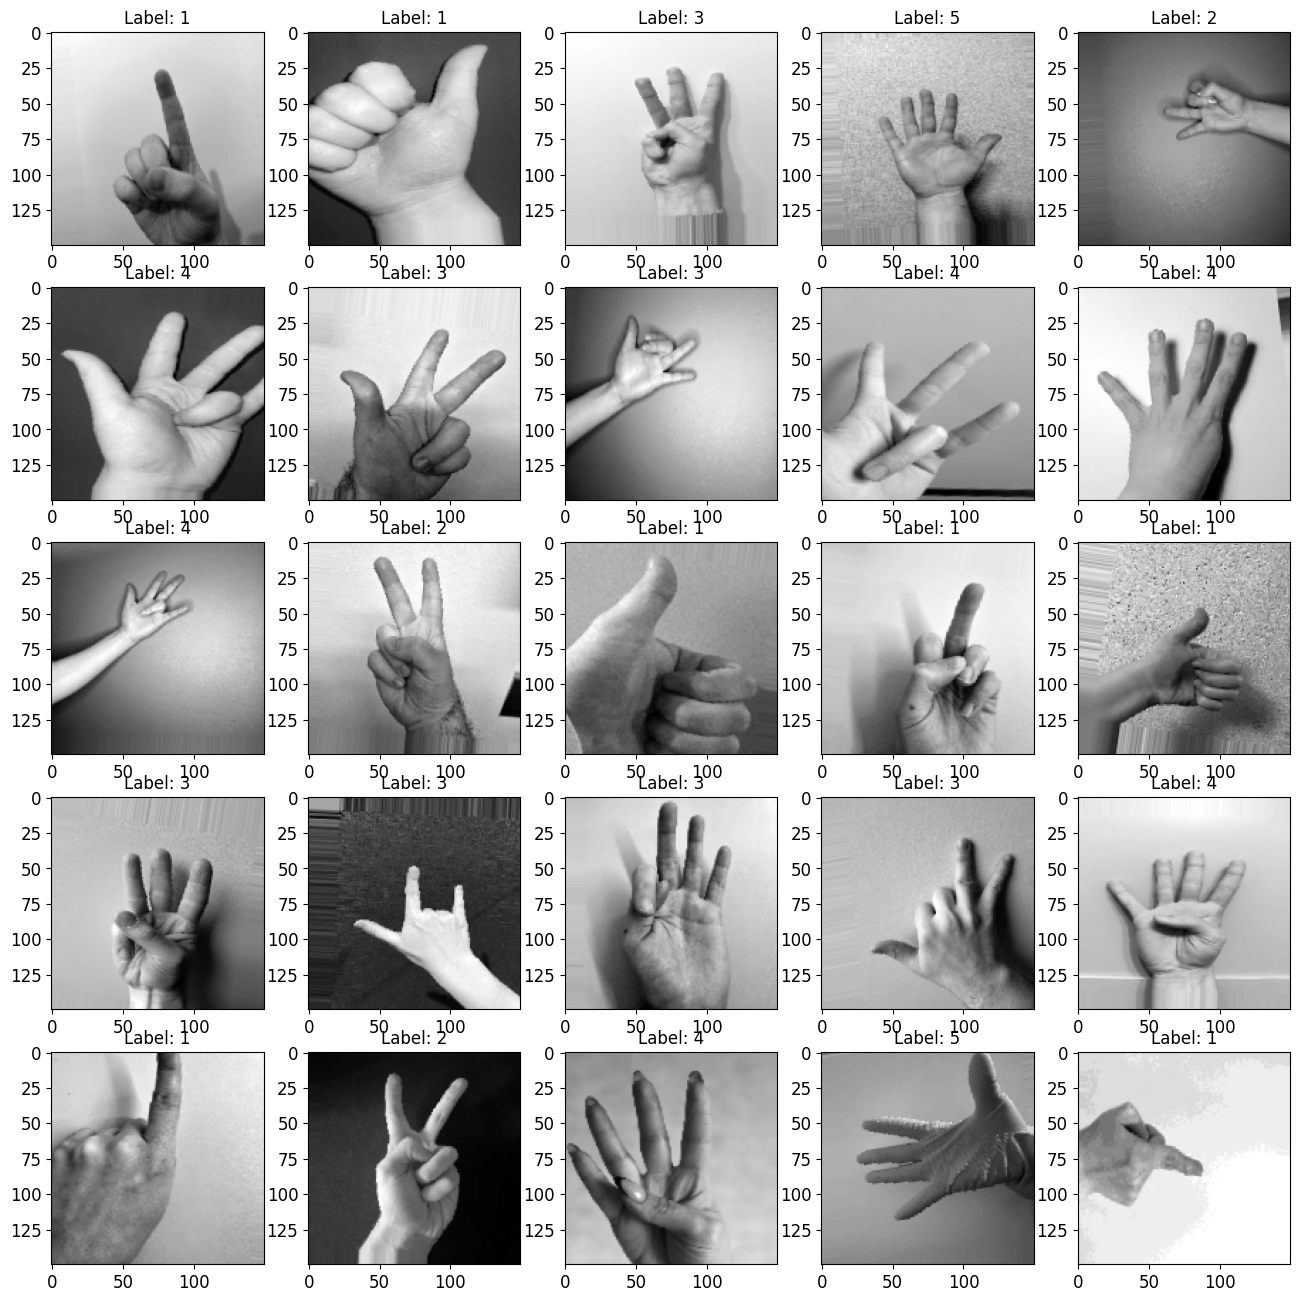

In [344]:
for X, y in train_gen:
  print(X.shape, y.shape)
    
  plt.figure(figsize=(16,16))
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.title('Label: %d' % np.argmax(y[i]))
    img = np.uint8(255*X[i,:,:,0])
    plt.imshow(img, cmap='gray')
  break

In [345]:
# model = Sequential()
# model.add(Conv2D(32, (3,3), activation='relu', input_shape=(300,300,3)))
# model.add(MaxPooling2D((2,2)))
# model.add(Conv2D(64, (3,3), activation='relu'))
# model.add(MaxPooling2D((2,2)))
# model.add(Conv2D(128, (3,3), activation='relu'))
# model.add(MaxPooling2D((2,2)))
# model.add(Conv2D(128, (3,3), activation='relu'))
# model.add(MaxPooling2D((2,2)))
# #model.add(Flatten())
# model.add(Dense(512, activation='sigmoid'))
# model.add(Dropout(0.3))
# model.add(Dense(5, activation='sigmoid'))

# #model.summary()

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(DIM, DIM, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])


In [346]:


model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'])

In [347]:

history = model.fit(
    train_gen,
    epochs=10,
    validation_data=test_gen
)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 264ms/step - accuracy: 0.2041 - loss: 1.7707 - val_accuracy: 0.1400 - val_loss: 1.7433
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 322ms/step - accuracy: 0.1993 - loss: 1.7417 - val_accuracy: 0.2200 - val_loss: 1.7226
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 425ms/step - accuracy: 0.1988 - loss: 1.7209 - val_accuracy: 0.2000 - val_loss: 1.7065
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 396ms/step - accuracy: 0.2043 - loss: 1.7047 - val_accuracy: 0.1800 - val_loss: 1.6932
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 409ms/step - accuracy: 0.2029 - loss: 1.6919 - val_accuracy: 0.2200 - val_loss: 1.6830
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 399ms/step - accuracy: 0.1862 - loss: 1.6843 - val_accuracy: 0.2600 - val_loss: 1.6754
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 409ms/step - accuracy: 0.2148 - loss: 1.6739 - val_accuracy: 0.2400 - val_loss: 1.6687
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 436ms/step - accuracy: 0.2167 - loss: 1.6687 - val_accur

Text(0.5, 0, '# of epochs')

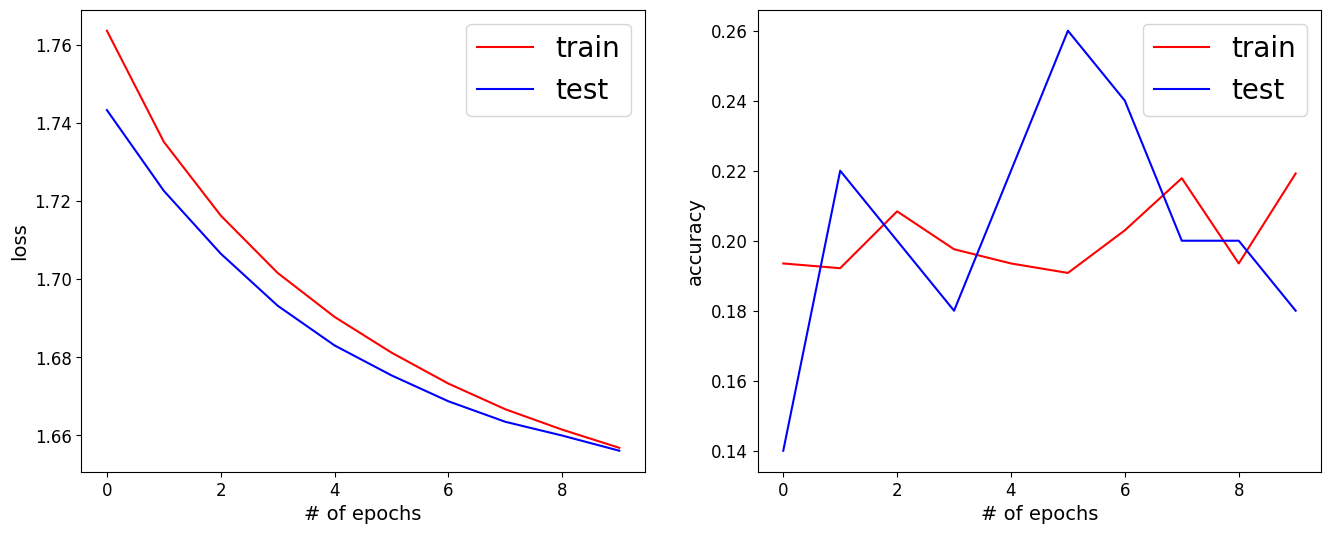

In [350]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
nepochs=len(history.history['loss'])
plt.plot(range(nepochs), history.history['loss'],     'r-', label='train')
plt.plot(range(nepochs), history.history['val_loss'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('loss')
plt.xlabel('# of epochs')
plt.subplot(1,2,2)
plt.plot(range(nepochs), history.history['accuracy'],     'r-', label='train')
plt.plot(range(nepochs), history.history['val_accuracy'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('accuracy')
plt.xlabel('# of epochs')

In [353]:
test_datagen  = ImageDataGenerator( rescale=1./255, 
                                    rotation_range=10.,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True
                                  )

test_gen = test_datagen.flow_from_directory(
        'rokas_validate',
        target_size=(DIM, DIM),
        color_mode='grayscale',
        batch_size=nbatch,
        classes=['0','1','2','3','4','5'],
        class_mode='categorical'
    )

Found 50 images belonging to 6 classes.


In [354]:
X_test, y_test = [], []
for ibatch, (X, y) in enumerate(test_gen):
    X_test.append(X)
    y_test.append(y)
    ibatch += 1
    if (ibatch == 5*28): break

# Concatenate everything together
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)
y_test = np.int32([np.argmax(r) for r in y_test])

# Get the predictions from the model and calculate the accuracy
y_pred = np.int32([np.argmax(r) for r in model.predict(X_test)])
match = (y_test == y_pred)
print('Testing Accuracy = %.2f%%' % (np.sum(match)*100/match.shape[0]))

219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
Testing Accuracy = 20.57%


In [355]:
nomatch = (y_test != y_pred)
bad_pred = y_pred[nomatch]
bad_true = y_test[nomatch]
bad_img = X_test[nomatch]
print('%d examples of bad predictions' % bad_pred.size)

5560 examples of bad predictions


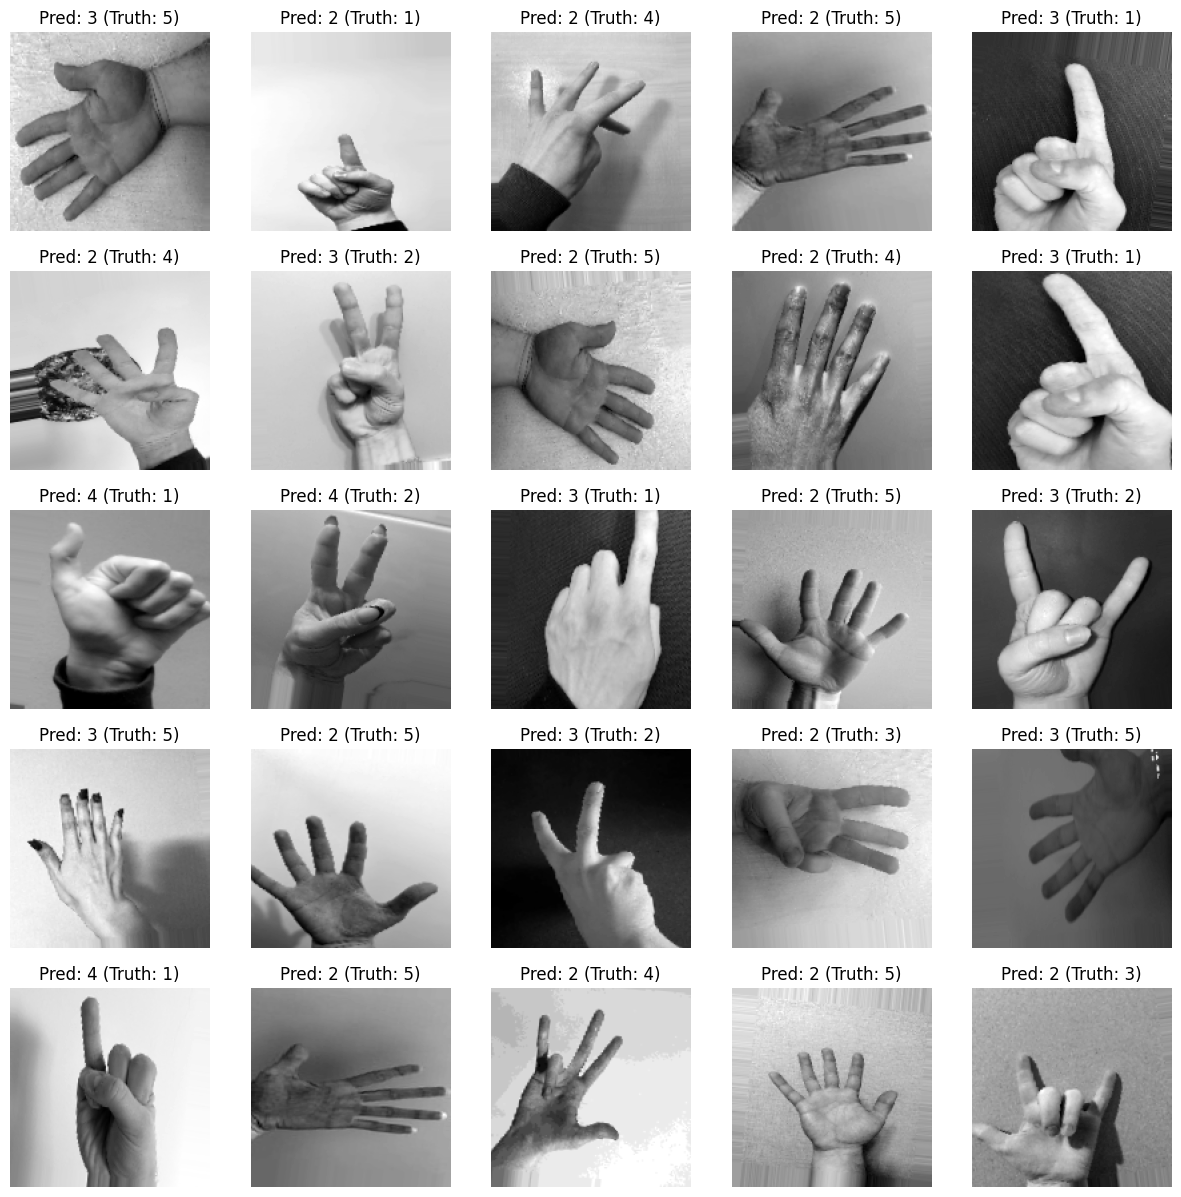

In [356]:
plt.figure(figsize=(15,15))
for i in range(min(bad_true.size,25)):
    plt.subplot(5,5,i+1)
    i+=75
    plt.title('Pred: %d (Truth: %d)' % (bad_pred[i], bad_true[i]))
    plt.axis('off')
    plt.imshow(bad_img[i][:,:,0], cmap='gray')